### Select correct amount of pretraining and training data which optimizes prediciton of human data

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
# funcs stolen from nyu deep learning course
import os
import random

In [4]:
def load_this_res(train_setting, prop_pretrain_setting, job_idx):
    
    #if train_setting == 2:
    #    print(job_idx)
    
    on_cluster = True
    if on_cluster:
        to_save_folder = '/scratch/gpfs/erussek/RNN_project/train_on_sim_and_human_results'
    else:
        to_save_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Code/RNNs/train_on_sim_and_human_results'
    # save loss curve
    loss_file_name = 'loss_res_train_setting_{}_pp_{}_job_{}.npy'.format(train_setting,prop_pretrain_setting,job_idx)
    loss_full_file_name = os.path.join(to_save_folder, loss_file_name)

   # print(loss_file_name)
    with open(loss_full_file_name, 'rb') as f:
        sim_loss_res = np.load(f)
        human_loss_res = np.load(f)
        train_num = np.load(f)
        r_sim_by_n_back = np.load(f)
        r_human_by_n_back = np.load(f)
    
    return sim_loss_res,human_loss_res,train_num,r_sim_by_n_back,r_human_by_n_back


def load_all_res(train_setting, prop_pretrain_setting):
    
    # just load one to get the size
    job_idx=0
    sim_loss_res,human_loss_res,train_num,r_sim_by_n_back,r_human_by_n_back=load_this_res(train_setting, prop_pretrain_setting, job_idx)

    all_jobs = np.arange(50)
    if train_setting < 2:
        bad_jobs = []
    else:
        bad_jobs = [1,10]
    
    good_jobs = np.delete(all_jobs,bad_jobs);
    

    n_train_examples = len(sim_loss_res)
    n_jobs = len(good_jobs)
    n_nback=19
    
    if train_setting == 2:
        n_nback=1

    all_sim_loss_res = np.zeros((n_jobs,n_train_examples))
    all_human_loss_res = np.zeros((n_jobs,n_train_examples))
    all_train_num = np.zeros((n_jobs,n_train_examples))
    all_r_sim_by_n_back = np.zeros((n_jobs,n_nback))
    all_r_human_by_n_back = np.zeros((n_jobs,n_nback))

    on_cluster = True
    for job_idx in range(len(good_jobs)):
        this_job = good_jobs[job_idx]
        sim_loss_res,human_loss_res,train_num,r_sim_by_n_back,r_human_by_n_back=load_this_res(train_setting, prop_pretrain_setting, this_job)
        all_sim_loss_res[job_idx, :] = sim_loss_res
        all_human_loss_res[job_idx, :] = human_loss_res
        all_train_num[job_idx, :] = train_num
        all_r_sim_by_n_back[job_idx, :] = r_sim_by_n_back
        all_r_human_by_n_back[job_idx, :] = r_human_by_n_back
        
    return all_sim_loss_res,all_human_loss_res,all_train_num,all_r_sim_by_n_back,all_r_human_by_n_back

Train Setting: 0
Pretrain Examples: 1500000, Best MSE: 5.681038236771862, N_Train: 1507232.0 
Pretrain Examples: 1125000, Best MSE: 5.681482688688463, N_Train: 1132832.0 
Pretrain Examples: 750000, Best MSE: 5.683799989454208, N_Train: 758432.0 
Pretrain Examples: 375000, Best MSE: 5.6940994490346615, N_Train: 387232.0 
Pretrain Examples: 0, Best MSE: 5.747606493580727, N_Train: 64032.0 
Train Setting: 1
Pretrain Examples: 1500000, Best MSE: 5.73464784560665, N_Train: 1504032.0 
Pretrain Examples: 1125000, Best MSE: 5.732299331849618, N_Train: 1132832.0 
Pretrain Examples: 750000, Best MSE: 5.733049273644724, N_Train: 755232.0 
Pretrain Examples: 375000, Best MSE: 5.742694645697071, N_Train: 387232.0 
Pretrain Examples: 0, Best MSE: 5.779432582547588, N_Train: 32032.0 
Train Setting: 2
Pretrain Examples: 1500000, Best MSE: 4.958869895947876, N_Train: 19232.0 
Pretrain Examples: 1125000, Best MSE: 4.958869895947876, N_Train: 19232.0 
Pretrain Examples: 750000, Best MSE: 4.95886989594787

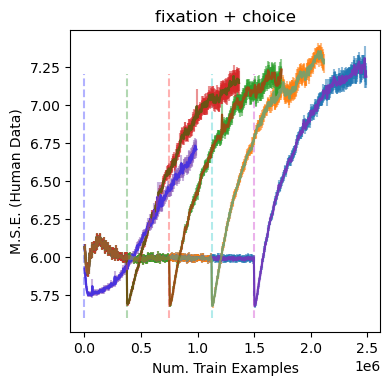

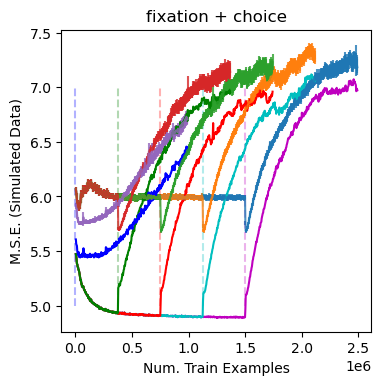

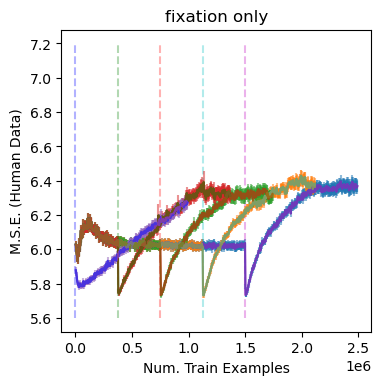

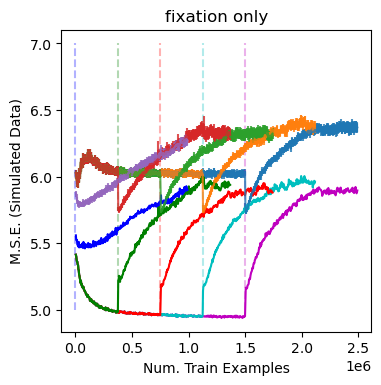

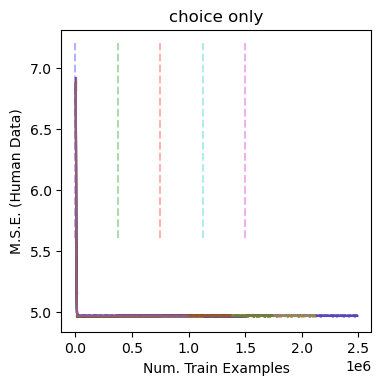

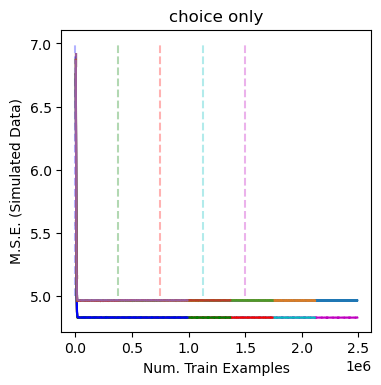

In [5]:
n_pretrain = np.round(np.linspace(0,1,5)*1.5e6).astype(int);
these_colors = ['b', 'g', 'r', 'c', 'm']

titles = ['fixation + choice', 'fixation only', 'choice only']

for train_setting in range(3):
    print('Train Setting: {}'.format(train_setting))

    fig,ax = plt.subplots(1,figsize=(4,4),dpi=100)
    for pretrain_idx in range(4,-1,-1):
        all_sim_loss_res_fc,all_human_loss_res_fc,all_train_num_fc,all_r_sim_by_n_back_fc,all_r_human_by_n_back_fc=load_all_res(train_setting,pretrain_idx)
        #ax.plot(all_train_num_fc[1,:],np.mean(all_sim_loss_res_fc,0))
        min_val = np.amin(np.mean(all_human_loss_res_fc,0))
        min_idx = np.argmin(np.mean(all_human_loss_res_fc,0))
        min_train_num = all_train_num_fc[0,min_idx]#-n_pretrain[pretrain_idx]
        print("Pretrain Examples: {}, Best MSE: {}, N_Train: {} ".format(n_pretrain[pretrain_idx],min_val,min_train_num))

        ax.plot(all_train_num_fc[1,:],np.mean(all_human_loss_res_fc,0), these_colors[pretrain_idx])
        ax.errorbar(all_train_num_fc[1,:],np.mean(all_human_loss_res_fc,0), np.std(all_human_loss_res_fc,0)/np.sqrt(50), alpha=.5)
        ax.vlines(n_pretrain[pretrain_idx], 5.6,7.2, these_colors[pretrain_idx], linestyles='dashed',alpha=.3)

    ax.set_ylabel('M.S.E. (Human Data)')
    ax.set_xlabel('Num. Train Examples')
    ax.set_title(titles[train_setting])
    
    fig,ax = plt.subplots(1,figsize=(4,4),dpi=100)

    for pretrain_idx in range(4,-1,-1):
        all_sim_loss_res_fc,all_human_loss_res_fc,all_train_num_fc,all_r_sim_by_n_back_fc,all_r_human_by_n_back_fc=load_all_res(train_setting,pretrain_idx)
        ax.plot(all_train_num_fc[1,:],np.mean(all_sim_loss_res_fc,0), these_colors[pretrain_idx])
        ax.errorbar(all_train_num_fc[1,:],np.mean(all_human_loss_res_fc,0), np.std(all_human_loss_res_fc,0)/np.sqrt(50), alpha=.8)

        ax.vlines(n_pretrain[pretrain_idx], 5,7, these_colors[pretrain_idx], linestyles='dashed',alpha=.3)
    ax.set_ylabel('M.S.E. (Simulated Data)')
    ax.set_xlabel('Num. Train Examples')
    ax.set_title(titles[train_setting])


In [83]:
# 0 -- 
# Pretrain Examples: 750000, Best MSE: 5.683799989454208, N_Train: 8432.0 

# 1
# Pretrain Examples: 750000, Best MSE: 5.733049273644724, N_Train: 5232.0 

# 2: 0, 500000

